***Exploring the neural dynamics of finger movements from human ECoG data***

**Research Question**: What are the temporal and spectral dynamics of neural responses in the motor region during freely timed trials of a finger movement task? Does the analysis point towards coordinated or synchronized activity?

**Hypothesis**: I predict that there will be specific temporal and spectral patterns in neural responses corresponding to finger movements and that there is synchronized activity during finger movement tasks.




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import seaborn as sns
import pandas as pd
from scipy import signal
from scipy.io import loadmat
from scipy.fft import fft,rfft,fftfreq,rfftfreq
from sklearn.decomposition import PCA
from scipy import stats

bp_fingerflex = loadmat('/bp_fingerflex.mat')
bp_stim = loadmat('/bp_stim.mat')

In [2]:
elec_regions = bp_fingerflex['elec_regions'] + 1 # Add one to adjust for Python indexing starting at 0
data_full = bp_fingerflex['data'].T
stim = bp_stim['stim'].squeeze()
cue = bp_fingerflex['cue'].squeeze()
flex = bp_fingerflex['flex'].T

# Set sampling frequency
fs = 1000

# Extract the relevent electrodes (those within motor region)
data = data_full[elec_regions[:,0] == 1]

# Identify the specific electrode numbers
elec_num = np.where(elec_regions[:,0] == 1)[0]

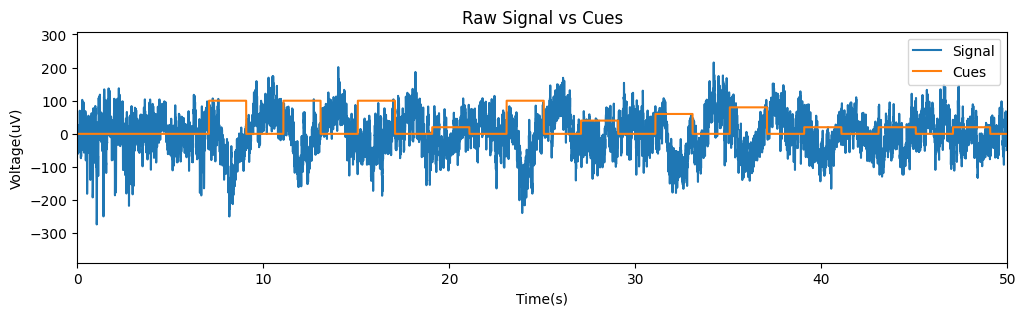

In [3]:
# Plot the raw signal and cues together, see if there is a relationship

# Create a time vector
t_data = np.arange(0, len(data.T)/fs, 1/fs)

fig1,ax = plt.subplots(figsize=(12,3))
ax.plot(t_data,data[0,:]/20, label='Signal')
ax.plot(t_data,cue*20, label='Cues')
ax.set(title='Raw Signal vs Cues',xlabel='Time(s)',ylabel='Voltage(uV)' ,xlim=[0,50])
ax.legend()
plt.show()

**Observation & Analysis:** The graph above depicts the initial 50 seconds of the study. I plot the raw signal from one electrode for easier visualization and to highlight the relationship between the signal and cues. There is an observable time gap between the cue presentation and the subsequent signal change. This temporal lag can be attributed to the inherent delay in a person's response initiation following the cue. It is evident that individuals require a brief period to transition from perceiving the cue to initiating movement.

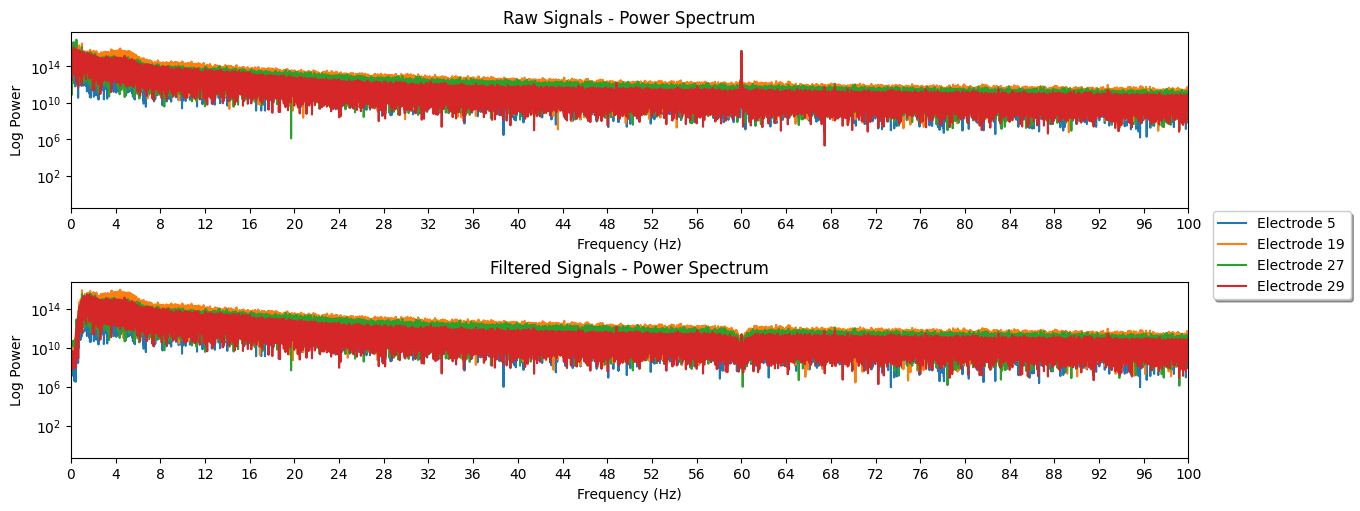

In [33]:
# Apply a notch filter at 60 Hz to remove electrical hum
def notch_filter(data,notch,quality_factor,fs=fs):
  b,a = signal.iirnotch(notch,quality_factor,fs)
  filtered_signal = signal.lfilter(b,a,data)
  return filtered_signal

data_notch = np.array([notch_filter(data=idx,notch=60,quality_factor=50) for idx in data])

# Apply a high pass filter at 1 Hz to remove noise
cutoff = 1
filt_coef = signal.firwin(3001,cutoff=cutoff, fs=fs, pass_zero=False)
data_filt = np.array([np.convolve(idx,filt_coef, mode='same') for idx in data_notch])

# Perform a Fourier Transform on the raw data and plot the power spectrum
fig2,ax = plt.subplots(2,1, constrained_layout=True, figsize=(12,5))
for row in data:
  ft = np.abs(rfft(row))
  ps = ft**2
  freq = rfftfreq(row.size, d=1/fs)

  ax[0].plot(freq, ps)
  ax[0].set(xlabel='Frequency (Hz)', ylabel='Log Power', title='Raw Signals - Power Spectrum')
  ax[0].set(xlim=[0,100], xticks=(np.arange(0,101,4)))
  ax[0].set_yscale('log')

# Do the same for the filtered data
for row,num in zip(data_filt,elec_num):
  ft_filt = np.abs(rfft(row))
  ps_filt = ft_filt**2
  freq_filt = rfftfreq(row.size, d=1/fs)
  #normalized_ps = ps_filt / np.max(ps_filt, axis=0) # If you wanted to plot normalized ps instead

  ax[1].plot(freq_filt, ps_filt, label=f'Electrode {num}')
  ax[1].set(xlabel='Frequency (Hz)', ylabel='Log Power', title='Filtered Signals - Power Spectrum')
  ax[1].set(xlim=[0,100], xticks=(np.arange(0,101,4)))
  ax[1].set_yscale('log')

fig2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True)
plt.show()

**Observation & Analysis:** The recorded signals possessed an inherent electrical hum at 60 Hz, which I eliminated using a notch filter. Additionally, to enhance the signal clarity for the specific analysis, I applied a high-pass filter at 1 Hz to remove noise below that frequency. Subsequently, I performed a Fourier Transform on both the raw and filtered signals to generate the power spectrum.

To facilitate a more discerning visualization of variations among electrodes, I used a log scale. The power spectrum analysis unveiled a prevalence of lower frequencies, notably theta oscillations, indicating their dominance. There was strong activity observed across other frequencies as well, including gamma oscillations.

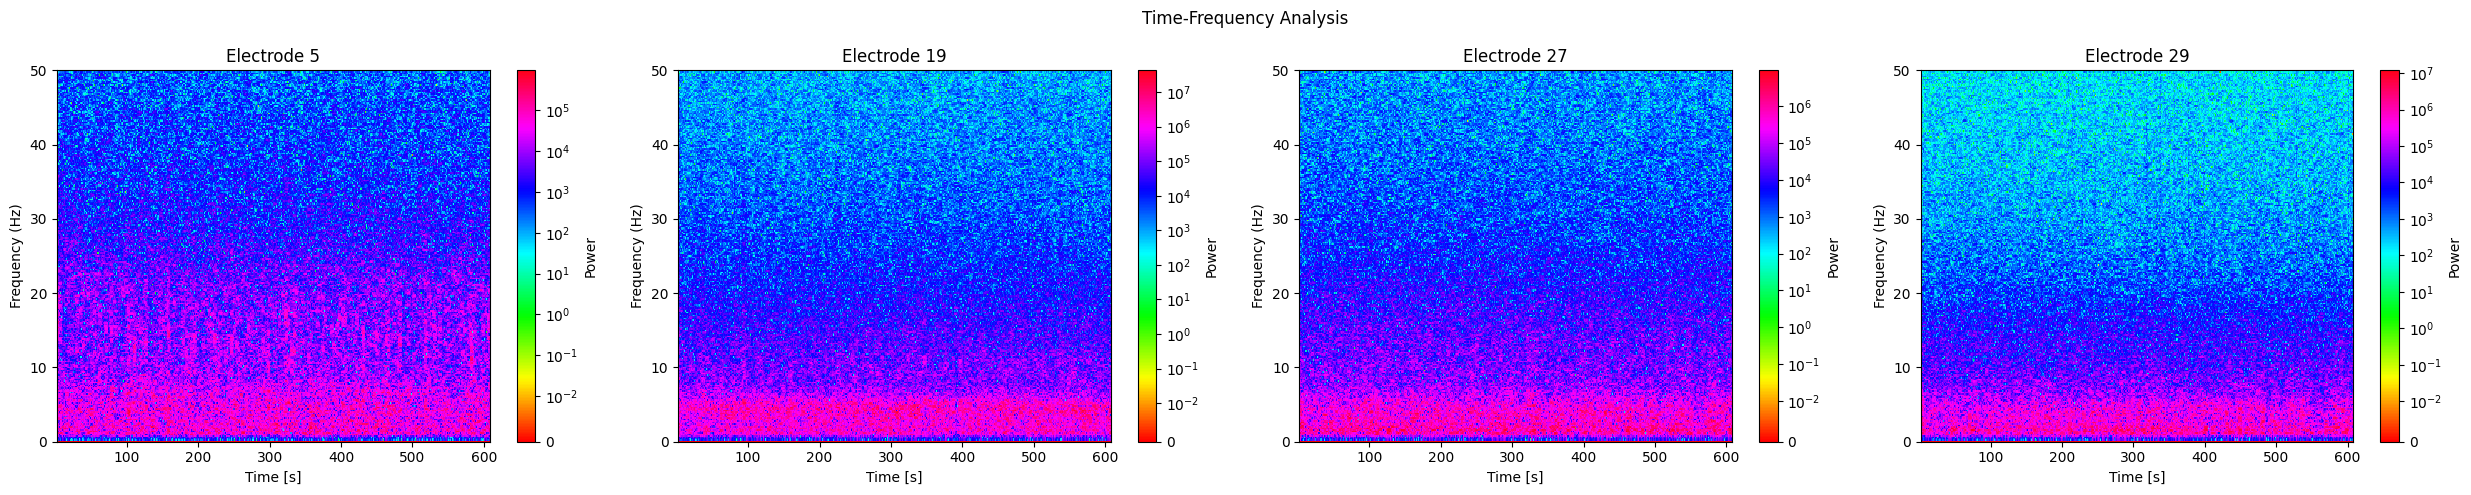

In [38]:
# Implement Short Time Fourier Transform to perform time-frequency analysis and observe
# changes in frequency bands along the entire duration of the data

# Define length of window and overlap
len_win = 5
len_overlap = 4
nperseg = int(len_win * fs)
noverlap = int(len_overlap * fs)

fig3, ax = plt.subplots(1, 4, figsize=(25, 5))

for i, electrode in enumerate(data_filt):
    f_sp, t_sp, spg = signal.spectrogram(electrode, fs=fs, window='boxcar', nperseg=nperseg, noverlap=noverlap)

    # Use SymLogNorm for a symmetric logarithmic scale
    sp = ax[i].pcolormesh(t_sp, f_sp, spg, shading='auto', cmap='hsv', norm=SymLogNorm(linthresh=0.01, linscale=1.0, vmin=spg.min(), vmax=spg.max()))
    ax[i].set(title=f'Electrode {elec_num[i]}', xlabel='Time [s]', ylabel='Frequency (Hz)', ylim=[0, 50])
    plt.colorbar(sp, ax=ax[i], label='Power')

fig3.suptitle('Time-Frequency Analysis')
plt.tight_layout()
plt.show()

**Observation & Analysis:** Next, my objective was to track the temporal evolution of frequency dynamics. To achieve this, I employed a Short Time Fourier Transform (STFT), enabling a comprehensive time-frequency analysis. The dominant frequencies observed in this plot align closely with those identified in the previously examined power spectrum. Important to mention is the stability in dominant frequencies over time, indicating a robust and consistent pattern of neural activity. The consistent patterns across electrodes suggest potentially coordinated neural responses during finger movement.

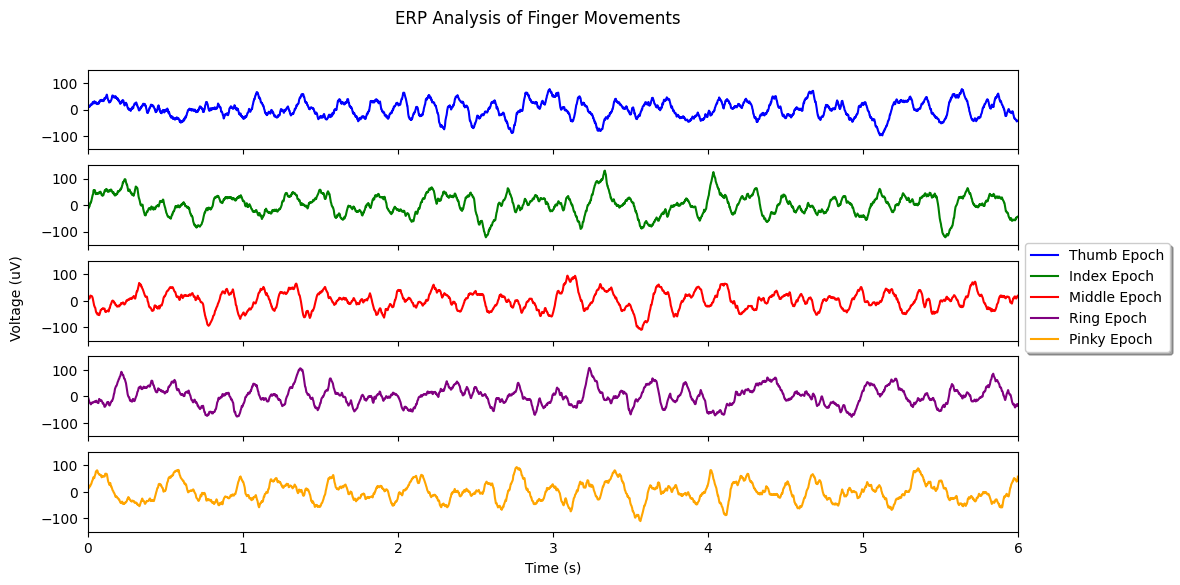

In [34]:
# Perform ERP analysis on finger movements
# Use PCA for dimensionality reduction
pca = PCA(n_components=1)
data_pca = (pca.fit_transform(data_filt.T)).squeeze()

# Define window parameters
len_pre = 0
len_post = 6.0

def extract_epochs_avg(stim, data, finger,len_pre=len_pre, len_post=len_post,fs=fs):
    start_indices = []  # Create an empty list to hold all the start indices
    i = 0
    while i < len(stim):  # Iterate through every element in the array
        if stim[i] == finger:
            start = i
            while stim[i] == finger:
                i += 1
            start_indices.append(start)  # Append the start index
        i += 1

    # Extract epochs using the start index
    epochs = np.array([data[start - int(fs*len_pre):start + int(fs*len_post)] for start in start_indices])
    epoch_avg = np.mean(epochs, axis=0)
    return epoch_avg


# Create time vector for epoched data
t_epoch = np.arange(-len_pre, len_post,1/fs)
finger_values = [1,2,3,4,5]

colors = ['blue', 'green', 'red', 'purple', 'orange']
finger_types = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

fig4,ax = plt.subplots(5,1, figsize=(12,6), sharex=True, sharey=True)
for i,finger in enumerate(finger_values):
  epoched_avg = extract_epochs_avg(stim=stim,data=data_pca,finger=finger)
  ax[i].plot(t_epoch, epoched_avg/20, label=f'{finger_types[i]} Epoch', color=colors[i])


ax[i].set(xlabel='Time (s)',xlim=[0,6] ,ylim=[-150,150])
fig4.text(0.06, 0.5, 'Voltage (uV)', va='center', rotation='vertical')
fig4.suptitle('ERP Analysis of Finger Movements')
fig4.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), shadow=True)

plt.show()

**Observation & Analysis:** Moving ahead, my focus shifted to Event-Related Potential (ERP) analysis aimed at exploring the temporal dynamics of neural responses during individual finger movements. To streamline the data for analysis, I opted for dimensionality reduction through Principal Component Analysis (PCA), projecting the data from the four electrodes onto a single principal component. This approach ensures that the reduced matrix preserves intricate patterns and relationships between electrodes.

To pinpoint epochs linked to finger movement accurately, I utilized the 'stim' variable instead of 'cue' as it contained the actual fingers patients moved, which sometimes differed from the cue. Also, despite the instructed 2 second finger movement duration upon cue presentation, I noticed that there were some instances where the patient moved their finger for up to 5 seconds. To encompass the entirety of relevant data, I extracted a 6 second window around the cue presentation.

Following the extraction of finger movement-related epochs for each specific finger, I averaged them and plotted the results against time. This visualization revealed distinct neural activity specific to each finger movement, characterized by differences in amplitude, waveform, and latency.

In [35]:
# Statistical analysis
all_epoched_avg = []

for finger in finger_values:
  epoched_avg = extract_epochs_avg(stim=stim, data=data_pca, finger=finger)
  all_epoched_avg.append(epoched_avg)

# Convert the list to a tuple so that each element is treated as a separate
# group when passed through f_oneway
all_epoched_avg_tuple = tuple(all_epoched_avg)

# Perform one-way repeated measures ANOVA. Use an asterisk for iterable unpacking
f_stat, p_value = stats.f_oneway(*all_epoched_avg_tuple)
print('F-statistic:', f'{f_stat:.4f}')
print('P-value:', f'{p_value:.4f}')

F-statistic: 3.5593
P-value: 0.0066


**Observation & Analysis:** In order to check if the differences seen in the previous ERP analysis were statistically significant, I performed a one way ANOVA test. The results showed a p-value <0.05, which indicates that the differences seen in the neural responses during each finger movement task were unlikely to be due to random chance. This statistical significance reinforces the reliability of the identified distinctions, providing confidence in the validity of the observed differences in the neural responses across the different finger movement tasks.

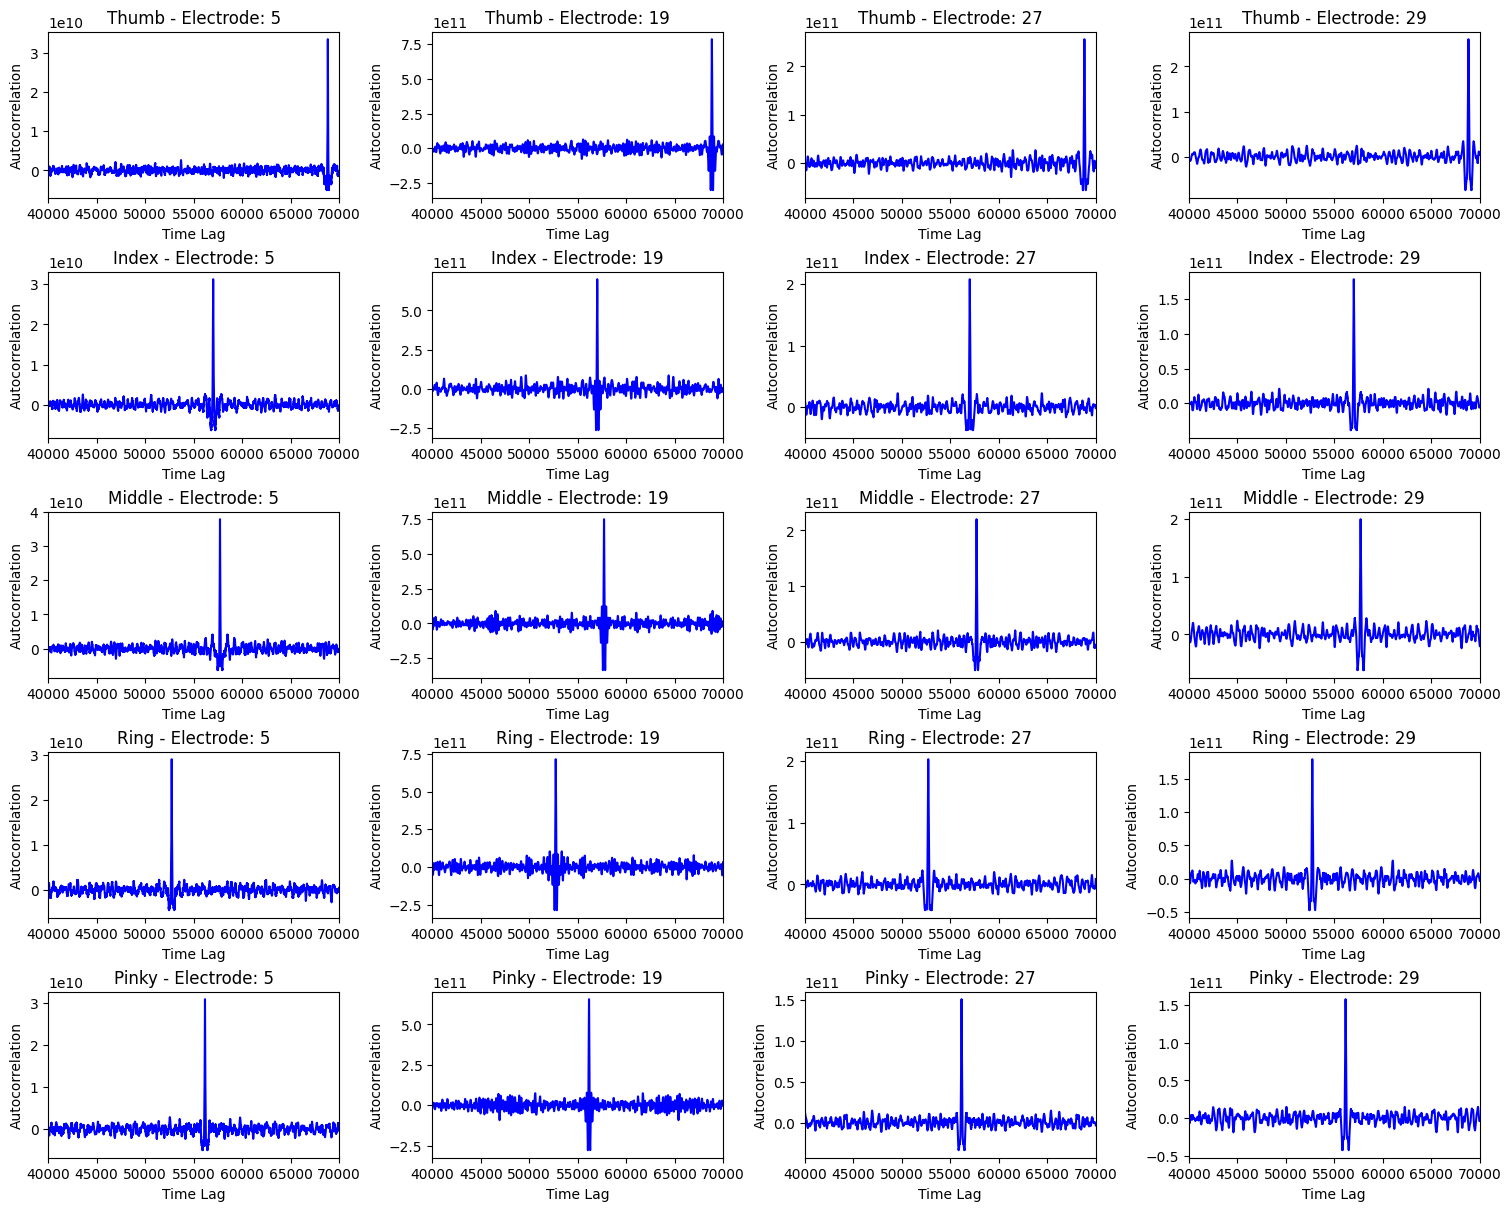

In [23]:
# Perform autocorrelation on each electrode during movement of a specific finger to
# assess whether there are recurring temporal patterns in the neural responses
# related to finger movements

fig, axs = plt.subplots(5,4, figsize=(15, 12), constrained_layout=True)

for i, finger in enumerate(finger_types):
  for j, electrode in enumerate(data_filt):
    # Compute autocorrelation
    autocorr_values = signal.correlate(electrode[stim == i + 1], electrode[stim == i + 1], mode='full')

    # Plot autocorrelation
    axs[i, j].plot(autocorr_values, ls='-', color='blue')
    axs[i, j].set_title(f'{finger} - Electrode: {elec_num[j]}')
    axs[i, j].set(xlabel='Time Lag', ylabel='Autocorrelation', xlim=[40000,70000])


plt.show()

**Observation & Analysis:**  The autocorrelation analysis played a crucial role in understanding the temporal dynamics of neural responses during finger movments. The consistent peak at a particular time lag across electrodes for each finger indicates a repeating temporal pattern associated with that finger's movement. This aligns with the ERP analysis findings that demonstrated differences in the temporal signatures of neural responses for each finger. Additionally, the observed temporal patterns support the notion that there is coordinated neural activity during finger movements.

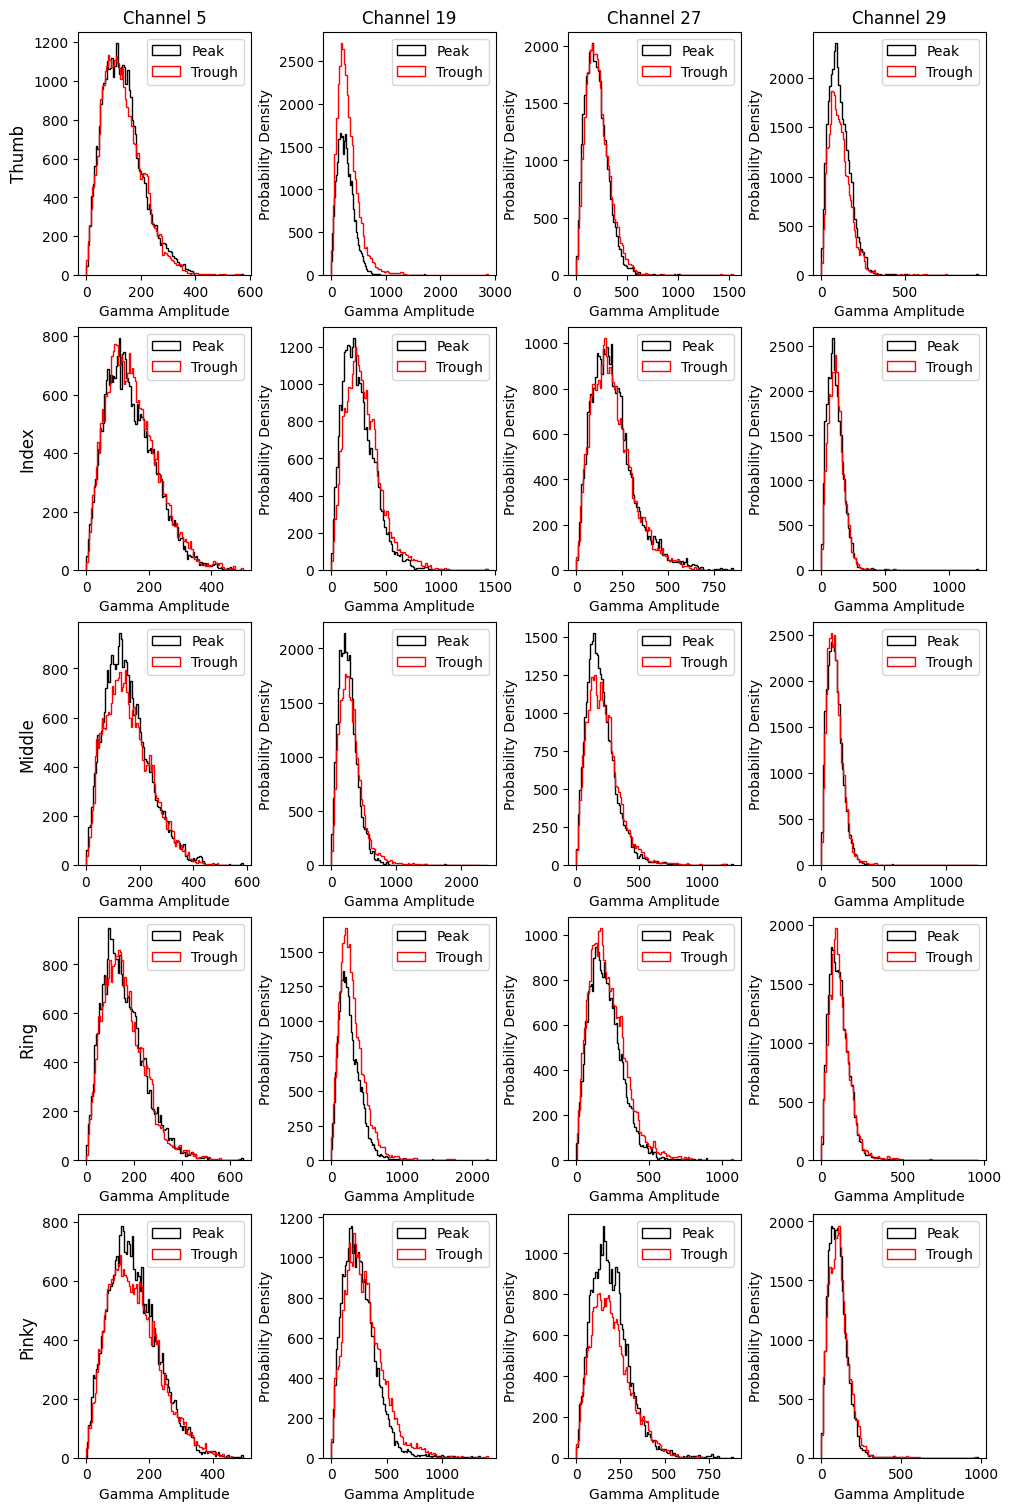

In [24]:
# Explore potential phase-amplitude coupling between theta and
# gamma oscillations during the finger movement tasks

fig5, axs = plt.subplots(5, 4, constrained_layout=True, figsize=(10, 15))

def compute_power_phase(analytic_signal):
  power = np.abs(analytic_signal)**2
  phase = np.angle(analytic_signal)
  return power, phase

# Create function that applies theta and gamma bandpass filters to the signal
def theta_gamma_pac(data_input, ax):
  FIR_theta = signal.firwin(numtaps=751, cutoff=(4, 8), fs=fs, pass_zero=False)
  FIR_gamma = signal.firwin(numtaps=251, cutoff=(30, 50), fs=fs, pass_zero=False)

  theta_osc = np.convolve(data_input, FIR_theta, mode='same')
  x_a_theta = signal.hilbert(theta_osc)
  theta_power, theta_phase = compute_power_phase(x_a_theta)

  gamma_osc = np.convolve(data_input, FIR_gamma, mode='same')
  x_a_gamma = signal.hilbert(gamma_osc)
  gamma_power, gamma_phase = compute_power_phase(x_a_gamma)

  # Obtain indices for when theta phase is at its peak or trough
  peak_idxs = np.where(np.logical_and(theta_phase > -np.pi/2, theta_phase < np.pi/2))[0]
  trough_idxs = np.where(np.logical_or(theta_phase < -np.pi/2, theta_phase > np.pi/2))[0]

  ax.hist(gamma_power[peak_idxs]**0.5, bins=100, color='k', histtype='step', label='Peak')
  ax.hist(gamma_power[trough_idxs]**0.5, bins=100, color='r', histtype='step', label='Trough')
  ax.set(xlabel='Gamma Amplitude', ylabel='Probability Density')
  ax.legend()

# Iterate over fingers and electrodes
for i, finger in enumerate(finger_types):
  for j, electrode in enumerate(data_filt):
    ax = axs[i, j]
    finger_data = electrode[stim == i + 1]
    theta_gamma_pac(finger_data, ax)

    # Set row and column labels
    if i == 0:
      ax.set_title(f'Channel {elec_num[j]}', fontsize=12)
    if j == 0:
      ax.set_ylabel(f'{finger}', fontsize=12)


plt.show()

**Observation & Analysis:** For my final analysis, I aimed to investigate the presence of phase-amplitude coupling (PAC) between theta and gamma oscillations, inspired by the findings reported in Canolty et al. (2006). The analysis revealed the existence of coupling between the phase of theta oscillations and the power of gamma oscillations during the movement of each finger. Gamma amplitude tended to be more modulated during the trough phase of theta oscillation. The PAC suggests a coordinated functional integration across neural networks.

**Conclusions:**

In this project, I employed a multi-faceted approach to examine the neural dynamics associated with finger movements. From time-frequency analysis revealing consistent patterns to ERP analysis uncovering unique finger-specific neural signatures. Autocorrelation illustrated synchronized temporal patterns across electrodes, while phase-amplitude coupling demonstrated the coordinated interplay of theta and gamma oscillations.

These observations have positive implications for the development of neural prosthetics involving finger movement. The ability to discern distinct temporal and spectral patterns for individual fingers enhances our understanding of neural coding, paving the way for more precise and effective neuroprosthetic devices.



**References:**

Miller, Kai J., Dora Hermes, Christopher J. Honey, Adam O. Hebb, Nick F. Ramsey, Robert T. Knight, Jeffrey G. Ojemann, and Eberhard E. Fetz. "Human motor cortical activity is selectively phase-entrained on underlying rhythms." PLoS computational biology 8, no. 9 (2012): e1002655.

Xiao, Ran, and Lei Ding. "EEG resolutions in detecting and decoding finger movements from spectral analysis." Frontiers in neuroscience 9 (2015): 308.

Canolty, R. T., Edwards, E., Dalal, S. S., Soltani, M., Nagarajan, S. S., Kirsch, H.E., Berger, M.S., Barbaro, N. M., & Knight, R.T. (2006). High gamma power is phase-locked to theta oscillations in human neocortex. Science, 313(5793), 1626-1628.

